In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

os.chdir('/Users/hausfath/Desktop/Climate Science/Carbon Brief/Age Carbon Emissions/')

population_data = 'WPP2017_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.xlsx'
national_emissions_data = 'GCB_Carbon_data.csv'
global_emissions_data = 'GCB_Global_data.csv'
emission_scenarios = 'emission_scenarios_ssp2_message.csv'
emissions_scen_regional = 'Future emission regional.xlsx'

ages = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
        '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']

In [2]:
#Import population data
pop_past = pd.read_excel(population_data, sheet_name = 'ESTIMATES', skiprows=16)
pop_future = pd.read_excel(population_data, sheet_name = 'MEDIUM VARIANT', skiprows=16)
pop = pop_past.append(pop_future, sort=True, ignore_index=True).drop_duplicates()
pop.columns = map(str.lower, pop.columns)
pop.drop_duplicates(subset=['region, subregion, country or area *', 'reference date (as of 1 july)'], inplace=True)

#Import emissions data post-1950
emissions = pd.read_csv(global_emissions_data)
emissions.columns = map(str.lower, emissions.columns)
emissions = emissions.loc[emissions['year'] >= 1900].reset_index(drop=True)

future_emissions = pd.read_csv(emission_scenarios)

In [120]:
national_emissions = pd.read_csv(national_emissions_data, encoding = "ISO-8859-1")
national_emissions.rename(columns={'Year':'year'}, inplace=True)
national_emissions.head()
rcp19_regional = pd.read_excel(emissions_scen_regional, sheet_name = 'RCP19')
rcp26_regional = pd.read_excel(emissions_scen_regional, sheet_name = 'RCP26')

In [4]:
global_pop = pop.loc[pop['region, subregion, country or area *'] == 'WORLD'].reset_index(drop=True)
current_pop = dict(zip(ages, global_pop.loc[global_pop['reference date (as of 1 july)'] == 2015][ages].values[0]))
global_pop['total'] = global_pop[ages].sum(skipna=True, axis=1)
global_pop.rename(columns={'reference date (as of 1 july)':'year'}, inplace=True)

In [5]:
global_emissions = pd.merge(
    emissions[['year', 'global']],
    future_emissions,
    left_on=['year'],
    right_on=['year'],
    how='outer'
)

per_capita_emissions = pd.merge(
    global_pop[['year', 'total']],
    global_emissions,
    left_on=['year'],
    right_on=['year'],
    how='outer'
)

per_capita_emissions.sort_values(by='year', inplace=True)
per_capita_emissions.set_index('year', inplace=True)
per_capita_emissions = per_capita_emissions.reindex(range(1900, 2101, 1))


per_capita_emissions['total'][1900] = 1650000
per_capita_emissions['total'][1910] = 1750000
per_capita_emissions['total'][1920] = 1860000
per_capita_emissions['total'][1930] = 2070000
per_capita_emissions['total'][1940] = 2300000

per_capita_emissions['pop_interp'] = per_capita_emissions['total'].interpolate(method='spline', order=3) 
per_capita_emissions['emissions_rcp1.9'].interpolate(method='spline', order=3, inplace=True) 
per_capita_emissions['emissions_rcp2.6'].interpolate(method='spline', order=3, inplace=True) 
per_capita_emissions['emissions_rcp1.9'] *= 10**6
per_capita_emissions['emissions_rcp2.6'] *= 10**6

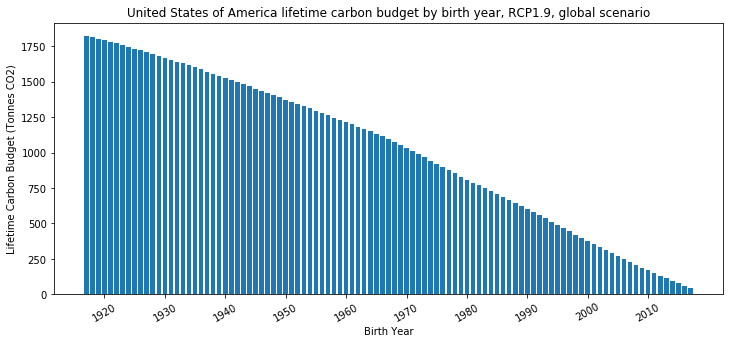

In [123]:
regions = ['China', 'India', 'United States of America', 'Indonesia', 'Brazil', 
           'Pakistan', 'Nigeria', 'Bangladesh', 'Russian Federation', 'Japan', 
           'Mexico', 'Philippines', 'Ethiopia', 'Egypt', 'Viet Nam', 'Germany', 
           'United Kingdom', 'France', 'Italy', 'Spain', 'Argentina', 'Canada', 'Australia',
           'AFRICA', 'EUROPE', 'LATIN AMERICA AND THE CARIBBEAN', 'OCEANIA', 'ASIA']


def map_regions_iams(region):
    if (region == 'China' or region == 'India' or region == 'ASIA' or region == 'Indonesia'
        or region == 'Pakistan' or region == 'Bangladesh' or region == 'Philippines'
        or region == 'Viet Nam'):
        return 'ASIA'
    if (region == 'United States of America' or region == 'Japan' or region == 'Germany' 
        or region == 'United Kingdom' or region == 'France' or region == 'Italy' 
        or region == 'Spain' or region == 'Canada' or region == 'EUROPE' or region == 'OCEANIA'
        or region == 'Australia'):
        return 'OECD90+EU'
    if (region == 'Brazil' or region == 'Argentina' or region == 'Mexico' 
        or region == 'LATIN AMERICA AND THE CARIBBEAN'):
        return 'LAM'
    if region == 'Russian Federation':
        return 'REF'
    if (region == 'Nigeria' or region == 'Ethiopia' or region == 'Egypt' or region == 'AFRICA'):
        return 'MAF'

    
def parse_regional_scenario(region):
    region_pop = pop.loc[pop['region, subregion, country or area *'] == region].reset_index(drop=True)
    region_pop['region_pop'] = region_pop[ages].sum(skipna=True, axis=1)
    region_pop.rename(columns={'reference date (as of 1 july)':'year'}, inplace=True)

    rcp_regional = rcp26_regional[['year']].copy()
    rcp_regional['rcp1.9'] = (
        rcp19_regional[map_regions_iams(region)] / 
        rcp19_regional[map_regions_iams(region)][1] *
        national_emissions[region][259]
    )
    rcp_regional['rcp2.6'] = (
        rcp26_regional[map_regions_iams(region)] / 
        rcp26_regional[map_regions_iams(region)][1] *
        national_emissions[region][259]
    )
    
    country_emissions = pd.merge(
        national_emissions[['year', region]],
        rcp_regional,
        left_on=['year'],
        right_on=['year'],
        how='outer'
    )
        
    country_per_cap = pd.merge(
        region_pop[['year', 'region_pop']],
        country_emissions,
        left_on=['year'],
        right_on=['year'],
        how='outer'
    )
    
    country_per_cap = country_per_cap.loc[country_per_cap['year'] >= 1900]
    
    country_per_cap.sort_values(by='year', inplace=True)
    country_per_cap.set_index('year', inplace=True)
    country_per_cap = country_per_cap.reindex(range(1900, 2101, 1))
    
    country_per_cap['pop_interp'] = country_per_cap['region_pop'].interpolate(method='spline', order=3) 
    country_per_cap['rcp1.9'].interpolate(method='spline', order=3, inplace=True) 
    country_per_cap['rcp2.6'].interpolate(method='spline', order=3, inplace=True) 
    return country_per_cap


def global_age_emissions(per_capita_emissions, rcp, end_year):
    if rcp == '2.6':
        emissions = per_capita_emissions['global'].fillna(per_capita_emissions['emissions_rcp2.6'])
    if rcp == '1.9':
        emissions = per_capita_emissions['global'].fillna(per_capita_emissions['emissions_rcp1.9'])
    per_capita_emissions['per_cap_emissions'] = (
        (emissions * 10**3) / (per_capita_emissions['pop_interp'] * 10**3)
        )
    budgets = []
    ages = np.arange(101)
    birth_year = 2017 - ages
    for age_group in ages:
        for year in range(end_year, 1900, -1):
            if year == end_year:
                budget = per_capita_emissions['per_cap_emissions'][year]
                age_temp = age_group + (end_year - 2017)
            elif age_temp > 0 and age_temp <= 100:
                budget += per_capita_emissions['per_cap_emissions'][year]
            age_temp -= 1
        budgets.append(budget)
    results = pd.DataFrame({'ages' : ages,
                            'birth_year' : birth_year,
                            'budget' : budgets})
    return results


def country_age_emissions(region, rcp, option, end_year=2100):
    country_per_cap = parse_regional_scenario(region)
    per_cap = country_per_cap.copy()
    if option == 'national':
        if rcp == '2.6':
            emissions = country_per_cap[region].fillna(country_per_cap['rcp2.6'])
        if rcp == '1.9':
            emissions = country_per_cap[region].fillna(country_per_cap['rcp1.9'])
        per_cap['per_cap_emissions'] = (
            (emissions * 10**3) / (country_per_cap['pop_interp'] * 10**3)
            )
    if option == 'global':
        if rcp == '2.6':
            emissions = country_per_cap[region].fillna(country_per_cap['rcp2.6'])
            global_emissions = per_capita_emissions['global'].fillna(per_capita_emissions['emissions_rcp2.6'])
        if rcp == '1.9':
            emissions = country_per_cap[region].fillna(country_per_cap['rcp1.9'])
            global_emissions = per_capita_emissions['global'].fillna(per_capita_emissions['emissions_rcp1.9'])
        per_cap['per_cap_emissions'] = (
            (emissions * 10**3) / (country_per_cap['pop_interp'] * 10**3)
            )
        per_cap['per_cap_global'] = (
            (global_emissions * 10**3) / (per_capita_emissions['pop_interp'] * 10**3)
            )
        per_cap.loc[2018:2101, 'per_cap_emissions'] = per_cap['per_cap_global']
    per_cap['per_cap_emissions'].fillna(method='backfill', inplace=True)
    budgets = []
    ages = np.arange(101)
    birth_year = 2017 - ages
    for age_group in ages:
        for year in range(end_year, 1900, -1):
            if year == end_year:
                budget = per_cap['per_cap_emissions'][year]
                age_temp = age_group + (end_year - 2017)
            elif age_temp > 0 and age_temp <= 100:
                budget += per_cap['per_cap_emissions'][year]
            age_temp -= 1
        budgets.append(budget)
    results = pd.DataFrame({'ages' : ages,
                            'birth_year' : birth_year,
                            'budget' : budgets})
    return results

def bar_plot(results, region, rcp, option, title):
    plt.figure(figsize=(12,5))
    plt.bar(results['birth_year'], results['budget'], width = 0.75)
    plt.xlabel('Birth Year', fontsize=10)
    plt.ylabel('Lifetime Carbon Budget (Tonnes CO2)', fontsize=10)
    plt.xticks(np.arange(1920, 2020, step=10),fontsize=10, rotation=30)
    plt.title(region+' lifetime carbon budget by birth year, RCP'+str(rcp)+', '+option+' scenario')
    plt.savefig('/Users/hausfath/Desktop/Climate Science/Carbon Brief/Age Carbon Emissions/Graphs/'+title+'.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

rcp = '1.9'
option = 'global'
region = regions[2]
results = country_age_emissions(region, rcp, option)
title = region+'_'+str(rcp)+'_'+option
results.to_csv('/Users/hausfath/Desktop/Climate Science/Carbon Brief/Age Carbon Emissions/Data/'+title+'.csv')
bar_plot(results, region, rcp, option, title)

#for rcp in ['1.9', '2.6']:
#    for option in ['national', 'global']:
#        for region in regions:
#            title = region+'_'+str(rcp)+'_'+option
#            results = country_age_emissions(region, rcp, option)
#            results.to_csv('/Users/hausfath/Desktop/Climate Science/Carbon Brief/Age Carbon Emissions/Data/'+title+'.csv')
#            bar_plot(results, region, rcp, option, title)